- tldr
- Intro / Problem / overview to set context
    - purpose of project:
        - acclimate to the technical environment (e.g., coding in Python, working in Jupyter notebooks, using Git)
    - recommendation
    - key lessons learned (e.g., working with messy data, importance of understanding the data you're anlayzing
        - 
        - 
- Approach / code
- Challenges / how we dealt with it
- Future steps to improve analysis

# Using NYC Subway data to determine the best location to hand out event flyers

Topic | Date | Name | Worked With
-----|------|-----
Explore MTA turnstile data |04/14/2016 |Max Melnick | Brian, David

# Getting the data

- Open up a new IPython notebook
- Download a few MTA turnstile data files
- Open up a file, use csv reader to read it, make a python dict where
  there is a key for each (C/A, UNIT, SCP, STATION). These are the
  first four columns. The value for this key should be a list of
  lists. Each list in the list is the rest of the columns in a
  row. For example, one key-value pair should look like


{    ('A002','R051','02-00-00','LEXINGTON AVE'):
[
['NQR456', 'BMT', '01/03/2015', '03:00:00', 'REGULAR', '0004945474', '0001675324'],
['NQR456', 'BMT', '01/03/2015', '07:00:00', 'REGULAR', '0004945478', '0001675333'],
['NQR456', 'BMT', '01/03/2015', '11:00:00', 'REGULAR', '0004945515', '0001675364'],
...
]
}

In [1]:
import csv
import urllib2
from datetime import datetime, time
import itertools
import numpy as np
import os
from collections import defaultdict
import glob

%matplotlib inline
import matplotlib.pyplot as plt
import random

import seaborn as sns
sns.set_style('whitegrid')

from math import floor

In [3]:
def readData():
    '''
    Utility function for reading the data we have stored on our local filesystem,
    transforming it into a format that we can more easily work with, and then
    returning a dictionary with all the data in the following structure:
    {
        (/A, UNIT, SCP, and STATION): [DATE_TIME as datetime object, entries as int]
    }
    '''
    #get all the data files we downloaded from the mta site and stored on our local filesystem
    filedir = './01-data/'
    filenames = sorted(next(os.walk(filedir))[2])
    #remove any hidden files (e.g., .DS_Store)
    for filename in filenames:
        if filename[0] == '.':
            filenames.remove(filename)
    
    my_dict = defaultdict(list)

    for nextfile in filenames:
        with open(filedir + nextfile, mode='r') as infile:
            reader = csv.reader(infile)
            readrows = [[cell.strip() for cell in row] for row in reader]
        
        #make sure our data has the same structure that we're expecting
        #using .pop() also discards the header from our data so we don't 
        #read that into our dictionary in the following for loop
        assert readrows.pop(0) == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
                               'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
                               'EXITS']

        # loop through each row, 
        for row in readrows:
            # set the key to the C/A, UNIT, SCP, and STATION combination since that 
            # uniquely identifies a record in the dataset
            key = tuple(row[:4])
            # combine the DATE and TIME fields to form one date and then convert to 
            # a datetime object for easier processing later on
            date_time = row[6] + " " + row[7]
            date_object = datetime.strptime(date_time, '%m/%d/%Y %H:%M:%S')
            entries = int(row[9])
            # add the data to the dictionary of turnstile data
            my_dict[key].append([date_object, entries])
        
        print filedir + nextfile + ' imported successfully'
        
    return my_dict

In [4]:
my_dict = readData()
print len(my_dict)

./01-data/turnstile_160227.txt imported successfully
./01-data/turnstile_160305.txt imported successfully
./01-data/turnstile_160312.txt imported successfully
./01-data/turnstile_160319.txt imported successfully
./01-data/turnstile_160326.txt imported successfully
./01-data/turnstile_160402.txt imported successfully
4606


In [5]:
# print some of the data to validate the structure is what we expected
test_key = ('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD')
test_entry = my_dict[test_key]
print test_entry[:10]

[[datetime.datetime(2016, 2, 20, 0, 0), 7195888], [datetime.datetime(2016, 2, 20, 4, 0), 7195906], [datetime.datetime(2016, 2, 20, 8, 0), 7195951], [datetime.datetime(2016, 2, 20, 12, 0), 7195995], [datetime.datetime(2016, 2, 20, 16, 0), 7196048], [datetime.datetime(2016, 2, 20, 20, 0), 7196062], [datetime.datetime(2016, 2, 21, 0, 0), 7196083], [datetime.datetime(2016, 2, 21, 4, 0), 7196101], [datetime.datetime(2016, 2, 21, 8, 0), 7196123], [datetime.datetime(2016, 2, 21, 12, 0), 7196159]]


### Transform turnstile data

The MTA provides cumulative entry and exit numbers for each turnstile. So that we can analyze the number of people that entered/exited the turnstiles during a 4-hour period, we need to transform the data from cumulative numbers to counts.

In [2]:
#setting the max number of people that can go through an individual turnstile in a 4hr period
#we'll use this for cleaning outliers in the data later on
upper_bound_count = 7000

In [6]:
def decumulate(entry, key):
    '''
    Function to convert turnstile entry data from cumulative to count
    '''
    entry = list(entry)
    entry = sorted(entry, key=lambda tup: tup[0])
    group_list = np.array(entry)
    date_times = group_list[:,0]
    # get rid of the first date/time entry since we can't get the count for it
    date_times = date_times[1:]
    entry_counts = np.diff(group_list[:,1])
    # check for negative entry counts and counts that are unusually high; we'll discard these outliers later
    try:
        if min(entry_counts) < 0:
            print '%s has negative values' % str(key)
        if max(entry_counts) > upper_bound_count:
            print '%s has unusually large values over %d' % (str(key),upper_bound_count)
    except:
        print 'no data for %s' % str(key)
    date_times = np.reshape(date_times, (len(date_times),1))
    entry_counts = np.reshape(entry_counts, (len(entry_counts),1))
    return np.hstack((date_times,entry_counts)).tolist()

In [7]:
# convert all the cumulative entry count data to counts (i.e., difference from one turnstile reading to the next)
decumulate_dict = defaultdict(list)
for key, val in my_dict.iteritems():
    decumulate_dict[key] = decumulate(val, key)

('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD') has negative values
('A083', 'R125', '00-00-01', 'BROAD ST') has negative values
('H023', 'R236', '00-06-00', 'DEKALB AV') has negative values
('N111', 'R284', '00-06-01', 'CLINTON-WASH AV') has negative values
('H023', 'R236', '00-00-02', 'DEKALB AV') has negative values
('R252', 'R180', '00-00-01', '103 ST') has unusually large values over 7000
('N547', 'R420', '01-06-01', 'DITMAS AV') has negative values
('N324', 'R018', '00-03-01', 'JKSN HT-ROOSVLT') has negative values
no data for ('R170', 'R191', '00-05-01', '103 ST')
('R533', 'R055', '00-00-03', 'FLUSHING-MAIN') has negative values
('N502', 'R021', '01-06-00', '42 ST-BRYANT PK') has unusually large values over 7000
('R142', 'R293', '01-00-00', '34 ST-PENN STA') has negative values
('H023', 'R236', '00-06-01', 'DEKALB AV') has negative values
no data for ('R170', 'R191', '00-00-03', '103 ST')
('R514', 'R094', '00-00-02', 'ASTORIA BLVD') has negative values
('R139', 'R031', '04-06-00',

In [8]:
# print some of the data to validate the structure is what we expected
print decumulate_dict[test_key][:10]

[[datetime.datetime(2016, 2, 20, 4, 0), 18], [datetime.datetime(2016, 2, 20, 8, 0), 45], [datetime.datetime(2016, 2, 20, 12, 0), 44], [datetime.datetime(2016, 2, 20, 16, 0), 53], [datetime.datetime(2016, 2, 20, 20, 0), 14], [datetime.datetime(2016, 2, 21, 0, 0), 21], [datetime.datetime(2016, 2, 21, 4, 0), 18], [datetime.datetime(2016, 2, 21, 8, 0), 22], [datetime.datetime(2016, 2, 21, 12, 0), 36], [datetime.datetime(2016, 2, 21, 16, 0), 23]]


In [9]:
# get rid of negative counts and unusually high counts
clean_dict = {key: [(date_time, count)
                    for (date_time, count) in values
                    if 0 <= count <= upper_bound_count] 
              for key, values in decumulate_dict.iteritems() }

#### Aggregate the data for a single turnstile by day

In [10]:
date_agg_dict = {}
for key in clean_dict:
    date_agg_dict[key] = [(dt, sum(v for d, v in grp))
            for dt, grp in itertools.groupby(clean_dict[key], 
                                             key=lambda x: x[0].date())]

In [11]:
# print some of the data to validate the structure is what we expected
print test_key
print date_agg_dict[test_key]

('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD')
[(datetime.date(2016, 2, 20), 174), (datetime.date(2016, 2, 21), 145), (datetime.date(2016, 2, 22), 1416), (datetime.date(2016, 2, 23), 1443), (datetime.date(2016, 2, 24), 1395), (datetime.date(2016, 2, 25), 1519), (datetime.date(2016, 2, 26), 1413), (datetime.date(2016, 2, 27), 748), (datetime.date(2016, 2, 28), 581), (datetime.date(2016, 2, 29), 1462), (datetime.date(2016, 3, 1), 1557), (datetime.date(2016, 3, 2), 1352), (datetime.date(2016, 3, 3), 1503), (datetime.date(2016, 3, 4), 1374), (datetime.date(2016, 3, 5), 768), (datetime.date(2016, 3, 6), 630), (datetime.date(2016, 3, 7), 1495), (datetime.date(2016, 3, 8), 1527), (datetime.date(2016, 3, 9), 1546), (datetime.date(2016, 3, 10), 1556), (datetime.date(2016, 3, 11), 1521), (datetime.date(2016, 3, 12), 818), (datetime.date(2016, 3, 13), 646), (datetime.date(2016, 3, 14), 1399), (datetime.date(2016, 3, 15), 1517), (datetime.date(2016, 3, 16), 1579), (datetime.date(2016, 3, 17), 1552)

# Challenge 4

In [12]:
# reusable function to plot entry counts over time
def plotEntries(dictionary, *key):
    # if no key is specified, choose a random one use and plot
    if not key:
        key = random.choice(dictionary.keys())
    print key
    vals = np.array(dictionary[key])
    dates = vals[:,0]
    counts = vals[:,1]
    plt.figure(figsize=(10,3))
    plt.plot(dates,counts)

('B027', 'R136', '00-00-05', 'SHEEPSHEAD BAY')


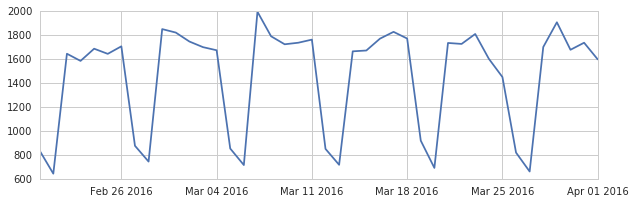

In [13]:
plotEntries(date_agg_dict)

('R101', 'R001', '02-07-03', 'SOUTH FERRY')


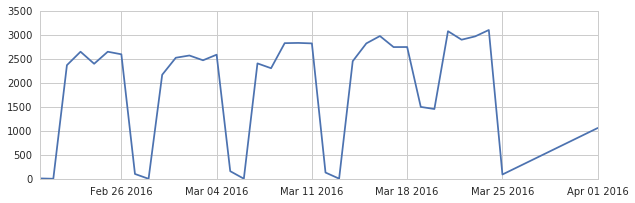

In [14]:
plotEntries(date_agg_dict, *('R101', 'R001', '02-07-03', 'SOUTH FERRY'))

('R262B', 'R195', '05-00-00', '161/YANKEE STAD')


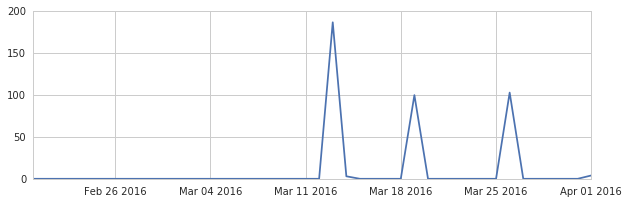

In [15]:
plotEntries(date_agg_dict, *('R262B', 'R195', '05-00-00', '161/YANKEE STAD'))

# Challenge 5

So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, different values for the SCP column.

We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.

In [16]:
''' 
aggregates data in a dictionary based on specified dictionary key tuple indexes
(e.g., a dictionary key of (C/A, UNIT, SCP, STATION) with tup_indexes_list = [0,1,3]
will aggregate the data using a sum function over (C/A, UNIT, STATION) and return
the resulting group/aggregated dictionary
'''
def aggregate(dictionary, tup_indexes_list):
    return_dict = defaultdict(list)
    for key, val in dictionary.iteritems():
        new_key = tuple()
        for i in tup_indexes_list:
            new_key = new_key + (key[i],)
        return_dict[new_key] = return_dict[new_key] + val
    
    random_test_key = random.choice(return_dict.keys())
    
    #consolidate values for each station
    for key, val in return_dict.iteritems():
        val = sorted(val, key=lambda tup: tup[0])
        return_dict[key] = [(dt, sum(v for d, v in grp))
                for dt, grp in itertools.groupby(val, 
                                                 key=lambda x: x[0])]
    
    return return_dict

In [17]:
# aggregate the data by (C/A, UNIT, STATION)
ca_unit_station_dict = aggregate(date_agg_dict, [0,1,3])

#### Old version:

```
ca_unit_station_dict = defaultdict(list)
for key, val in date_agg_dict.iteritems():
    new_key = (key[0],key[1],key[3])
    ca_unit_station_dict[new_key] = ca_unit_station_dict[new_key] + val

random_test_key2 = random.choice(ca_unit_station_dict.keys())

print random_test_key2
print ca_unit_station_dict[random_test_key2] 
print len(ca_unit_station_dict)

#consolidate values for each station
for key, val in ca_unit_station_dict.iteritems():
    val = sorted(val, key=lambda tup: tup[0])
    ca_unit_station_dict[key] = [(dt, sum(v for d, v in grp))
            for dt, grp in itertools.groupby(val, 
                                             key=lambda x: x[0])]

print ca_unit_station_dict[random_test_key2]
```

# Challenge 6

Similarly, combine everything in each station, and come up with a time series of `[(date1, count1),(date2,count2),...]` type of time series for each STATION, by adding up all the turnstiles in a station.

#### Old version:

```
station_dict = defaultdict(list)
for key, val in ca_unit_station_dict.iteritems():
    new_key = (key[2])
    station_dict[new_key] = station_dict[new_key] + val

random_test_key3 = random.choice(station_dict.keys())

print random_test_key3
print station_dict[random_test_key3] 
print len(station_dict)

#consolidate values for each station
for key, val in station_dict.iteritems():
    val = sorted(val, key=lambda tup: tup[0])
    station_dict[key] = [(dt, sum(v for d, v in grp))
            for dt, grp in itertools.groupby(val, 
                                             key=lambda x: x[0])]

print station_dict[random_test_key3]
```

In [18]:
# aggregate to STATION level
station_dict = aggregate(ca_unit_station_dict,[2])

# Challenge 7

Plot the time series for a station.

('34 ST-PENN STA',)


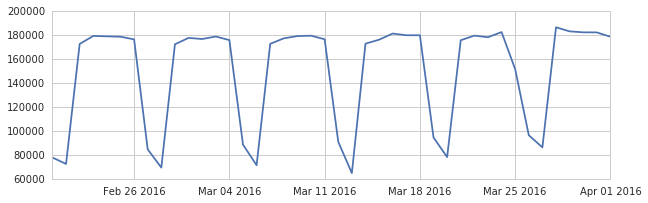

In [19]:
plotEntries(station_dict, '34 ST-PENN STA')

('14 ST-UNION SQ',)


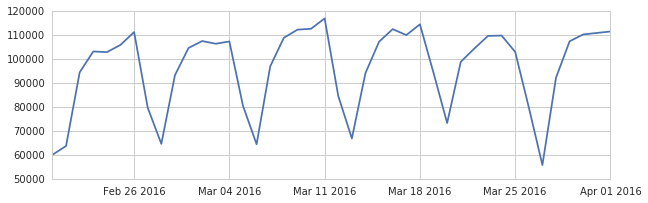

In [20]:
plotEntries(station_dict, '14 ST-UNION SQ')

# Challenge 8

Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

In [21]:
station_by_weekday = defaultdict(list)
for key, val in station_dict.iteritems():
    new_val = [(x[0].isocalendar()[1],x[0].weekday(),x[1]) for x in val]
    #make sure the values are sorted on week (primary) and day of week (secondary)
    new_val = sorted(new_val, key=lambda tup: (tup[0],tup[1]))
    week_count_list = []
    for week, grp in itertools.groupby(new_val, key=lambda x: x[0]):
        count_list = np.array(list(grp))
        week_count_list.append(count_list[:,[1,2]].tolist())
    station_by_weekday[key] = week_count_list

In [22]:
# print some of the data to validate the structure is what we expected
data_to_plot = station_by_weekday[('GRD CNTRL-42 ST',)]
print data_to_plot

[[[5, 51330], [6, 43367]], [[0, 148925], [1, 169314], [2, 170155], [3, 164359], [4, 159556], [5, 59969], [6, 43700]], [[0, 149175], [1, 159896], [2, 162703], [3, 167410], [4, 158500], [5, 61911], [6, 44410]], [[0, 149967], [1, 160501], [2, 159795], [3, 161977], [4, 158885], [5, 66496], [6, 42989]], [[0, 158698], [1, 161151], [2, 164466], [3, 169813], [4, 159892], [5, 63298], [6, 44287]], [[0, 150681], [1, 160074], [2, 161217], [3, 165122], [4, 121926], [5, 61294], [6, 47585]], [[0, 153365], [1, 159830], [2, 162079], [3, 159664], [4, 153872]]]


In [23]:
def plotByDayOfWeek(dictionary, *station_key):
    if not station_key:
        station_key = random.choice(dictionary.keys())
    print station_key
    for data in dictionary[station_key]:
        data = np.array(data)
        x = data[:,0]
        y = data[:,1]
        plt.plot(x,y)

# Challenge 9

- Over multiple weeks, sum total ridership for each station and sort
  them, so you can find out the stations with the highest traffic
  during the time you investigate

In [24]:
def getTotalVolume(values):
    values = np.array(values)
    counts = values[:,1]
    total_volume = sum(counts)
    return total_volume

In [25]:
total_station_volumes = []
for key, values in station_dict.iteritems():
    total_station_volumes.append([key[0], getTotalVolume(values)])

In [26]:
total_station_volumes = sorted(total_station_volumes, key=lambda x: -x[1])

In [27]:
total_station_volumes[:10]

[['34 ST-PENN STA', 6303386],
 ['GRD CNTRL-42 ST', 5393604],
 ['23 ST', 4420018],
 ['34 ST-HERALD SQ', 4360365],
 ['14 ST-UNION SQ', 4051288],
 ['86 ST', 4024439],
 ['TIMES SQ-42 ST', 3580323],
 ['42 ST-PORT AUTH', 3484418],
 ['59 ST', 2923739],
 ['96 ST', 2905291]]

# Challenge 10

- Make a single list of these total ridership values and plot it with

    plt.hist(total_ridership_counts)

to get an idea about the distribution of total ridership among
different stations.

This should show you that most stations have a small traffic, and the
histogram bins for large traffic volumes have small bars.

*Additional Hint*:

If you want to see which stations take the meat of the traffic, you
can sort the total ridership counts and make a `plt.bar` graph. For
this, you want to have two lists: the indices of each bar, and the
values. The indices can just be `0,1,2,3,...`, so you can do

    indices = range(len(total_ridership_values))
    plt.bar(indices, total_ridership_values)

In [28]:
total_ridership_counts = map(int, np.array(total_station_volumes)[:,1])

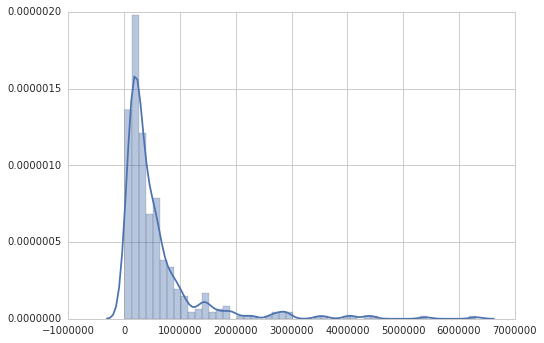

In [29]:
sns.distplot(total_ridership_counts)

<Container object of 373 artists>

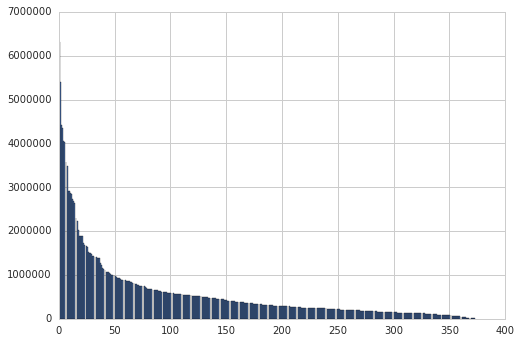

In [30]:
indices = range(len(total_station_volumes))
ar = np.array(total_station_volumes)
plt.bar(indices, ar[:,1])

# Now using Pandas...

In [31]:
import pandas as pd

from pandas import Series, DataFrame

In [32]:
def readDataToDF():
    path ='./01-data' # use your path
    allFiles = glob.glob(path + "/*.txt")
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    frame = pd.concat(list_)
    return frame

In [33]:
df = readDataToDF()

In [34]:
df['date_time'] = pd.to_datetime(df['DATE']+' '+df['TIME'], format='%m/%d/%Y %H:%M:%S')
df.sort_values(by=['C/A','UNIT','SCP','STATION','DATE','TIME'], inplace=True)

In [35]:
#fix the fact that the EXIT column name has trailing whitespace
df.columns = df.columns.str.strip()

In [36]:
df['entry_counts'] = np.nan 
df['entry_counts'] = df['ENTRIES'].diff()
df['exit_counts'] = np.nan 
df['exit_counts'] = df['EXITS'].diff()

In [37]:
mask = df.SCP != df.SCP.shift(1)
df['entry_counts'][mask] = np.nan
df['exit_counts'][mask] = np.nan

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [38]:
# filter outliers
df_clean = df[(df.entry_counts >= 0) & (df.entry_counts <= upper_bound_count) &
             (df.exit_counts >= 0) & (df.exit_counts <= upper_bound_count)]

In [39]:
df_dirty = df[(df.entry_counts < 0) | (df.entry_counts > upper_bound_count) |
             (df.exit_counts < 0) | (df.exit_counts > upper_bound_count)]

In [40]:
df_dirty.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,entry_counts,exit_counts
1591,A011,R080,01-00-00,57 ST-7 AV,NQR,BMT,02/20/2016,07:00:00,REGULAR,888203007,493928207,2016-02-20 07:00:00,-45,-101
1592,A011,R080,01-00-00,57 ST-7 AV,NQR,BMT,02/20/2016,11:00:00,REGULAR,888202790,493927773,2016-02-20 11:00:00,-217,-434
1593,A011,R080,01-00-00,57 ST-7 AV,NQR,BMT,02/20/2016,15:00:00,REGULAR,888202368,493927231,2016-02-20 15:00:00,-422,-542
1594,A011,R080,01-00-00,57 ST-7 AV,NQR,BMT,02/20/2016,19:00:00,REGULAR,888201761,493926747,2016-02-20 19:00:00,-607,-484
1595,A011,R080,01-00-00,57 ST-7 AV,NQR,BMT,02/20/2016,23:00:00,REGULAR,888201376,493926396,2016-02-20 23:00:00,-385,-351


In [42]:
df_clean.loc[:,'total_volume'] = df_clean['entry_counts'] + df_clean['exit_counts']

/opt/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [43]:
def getDayOfWeekReadable(num):
    map = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    return map[num]

In [44]:
df_clean.loc[:,'day_of_week_num'] = df_clean['date_time'].map(datetime.weekday)

In [45]:
df_clean.loc[:,'Day of Week'] = pd.Categorical(df_clean['day_of_week_num'].map(getDayOfWeekReadable), 
                                            ['Sun','Mon','Tue','Wed','Thu','Fri','Sat'])

In [46]:
# Takes a string representing a 24 hr time in the format of 'HH:MM:SS' and rounds it down to the nearest 4hrs
# e.g., 09:30:00 -> 8; 23:00:00 -> 20
def round_to_nearest_4_hrs(time_string):
    hr_map = [0,4,8,12,16,20,0]
    # 240 minutes = 4 hrs
    time_interval = 240
    hms = time_string.split(':')
    # calculate the time in seconds since the beginning of the day, and divide by 240 to get
    # which 4 hr period in the hr_map it's closest to (when rounded down)
    return hr_map[int(floor(float((int(hms[0])*60+int(hms[1])))/time_interval))]

In [47]:
df_clean.loc[:,'rounded_time'] = df_clean['TIME'].map(round_to_nearest_4_hrs)

In [48]:
def getTimeBin(time):
    map = {
        '0': '0-4',
        '4': '4-8',
        '8': '8-12',
        '12': '12-16',
        '16': '16-20',
        '20': '20-0'
    }
    return map[str(time)]

In [49]:
df_clean.loc[:,'Time of Day'] = pd.Categorical(df_clean['rounded_time'].map(getTimeBin), 
                                               ['0-4','4-8','8-12','12-16','16-20','20-0'])

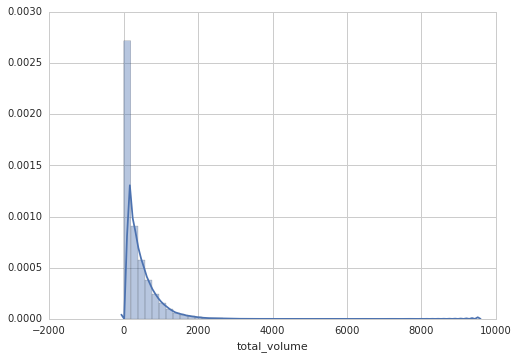

In [50]:
sns.distplot(df_clean.dropna().total_volume)

In [51]:
daily_station_counts = df_clean.groupby(by=['STATION','DATE'])['total_volume'].sum()

In [52]:
temp = df_clean.groupby(['STATION','DATE'])

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,entry_counts,exit_counts,total_volume,day_of_week_num,Day of Week,rounded_time,Time of Day
1,A002,R051,02-00-00,59 ST,NQR456,BMT,02/20/2016,07:00:00,REGULAR,5551567,1873919,2016-02-20 07:00:00,14,18,32,5,Sat,4,4-8
2,A002,R051,02-00-00,59 ST,NQR456,BMT,02/20/2016,11:00:00,REGULAR,5551664,1873999,2016-02-20 11:00:00,97,80,177,5,Sat,8,8-12
3,A002,R051,02-00-00,59 ST,NQR456,BMT,02/20/2016,15:00:00,REGULAR,5551960,1874072,2016-02-20 15:00:00,296,73,369,5,Sat,12,12-16
4,A002,R051,02-00-00,59 ST,NQR456,BMT,02/20/2016,19:00:00,REGULAR,5552383,1874159,2016-02-20 19:00:00,423,87,510,5,Sat,16,16-20
5,A002,R051,02-00-00,59 ST,NQR456,BMT,02/20/2016,23:00:00,REGULAR,5552655,1874197,2016-02-20 23:00:00,272,38,310,5,Sat,20,20-0
6,A002,R051,02-00-00,59 ST,NQR456,BMT,02/21/2016,03:00:00,REGULAR,5552728,1874205,2016-02-21 03:00:00,73,8,81,6,Sun,0,0-4
7,A002,R051,02-00-00,59 ST,NQR456,BMT,02/21/2016,07:00:00,REGULAR,5552740,1874217,2016-02-21 07:00:00,12,12,24,6,Sun,4,4-8
8,A002,R051,02-00-00,59 ST,NQR456,BMT,02/21/2016,11:00:00,REGULAR,5552808,1874275,2016-02-21 11:00:00,68,58,126,6,Sun,8,8-12
9,A002,R051,02-00-00,59 ST,NQR456,BMT,02/21/2016,15:00:00,REGULAR,5553058,1874347,2016-02-21 15:00:00,250,72,322,6,Sun,12,12-16
10,A002,R051,02-00-00,59 ST,NQR456,BMT,02/21/2016,19:00:00,REGULAR,5553313,1874418,2016-02-21 19:00:00,255,71,326,6,Sun,16,16-20


In [53]:
hourly_station_counts = df_clean.groupby(by=['STATION','TIME'])['total_volume'].sum()

In [54]:
station_group_by = df_clean.groupby(by=['STATION'])
total_station_volume = station_group_by['total_volume'].sum()
total_station_volume.sort_values(inplace=True,ascending=False)
total_station_volume.head()

STATION
34 ST-PENN STA     11647668
GRD CNTRL-42 ST    10267525
34 ST-HERALD SQ     8304692
23 ST               7729754
14 ST-UNION SQ      7529373
Name: total_volume, dtype: float64

In [55]:
top_stations = total_station_volume[:25]
top_stations.head()

STATION
34 ST-PENN STA     11647668
GRD CNTRL-42 ST    10267525
34 ST-HERALD SQ     8304692
23 ST               7729754
14 ST-UNION SQ      7529373
Name: total_volume, dtype: float64

In [56]:
def getStationPivot(station, *aggColumn):
    if not aggColumn:
        aggColumn = 'total_volume'
    else:
        aggColumn = aggColumn[0]
    return pd.pivot_table(df_clean[df_clean['STATION'] == station], values=aggColumn, index=['Day of Week'], 
               columns='Time of Day', aggfunc=np.mean)

/opt/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


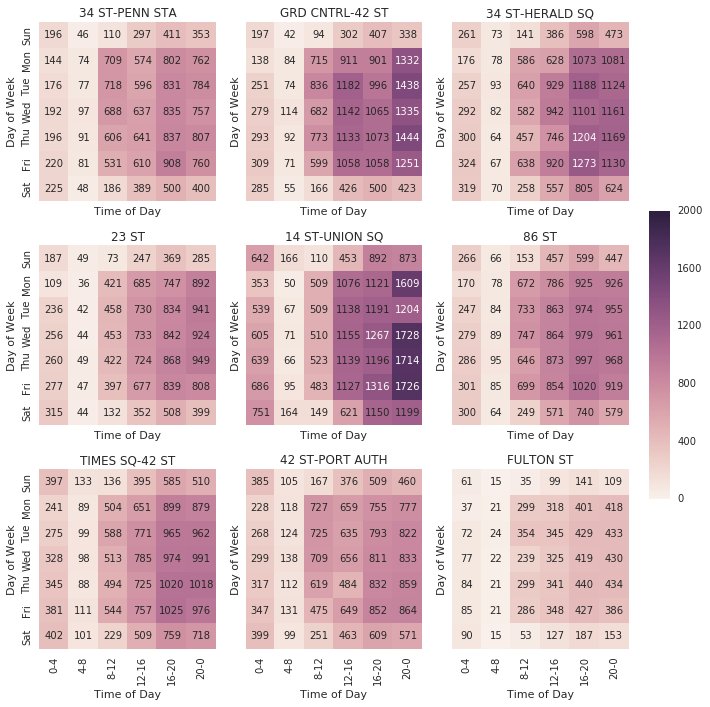

In [57]:
fig, axn = plt.subplots(3,3, sharex=True, sharey=True, figsize=(10,10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, ax in enumerate(axn.flat):
    station = top_stations.keys()[i]
    sns.heatmap(getStationPivot(station, 'total_volume'), ax=ax,
                cbar=i == 0,
                vmin= 0,
                vmax= 2000,
                cbar_ax=None if i else cbar_ax,
               annot=True,
               annot_kws={'size':'smaller'},
               fmt='.0f')
    ax.set_title(station)

fig.tight_layout(rect=[0, 0, .9, 1])
fig.savefig('./img/heatmap.png',format='png')

count      38.000000
mean      624.344775
std       442.302123
min        28.962025
25%       251.692134
50%       564.601266
75%       921.226190
max      1468.904762
Name: total_volume, dtype: float64


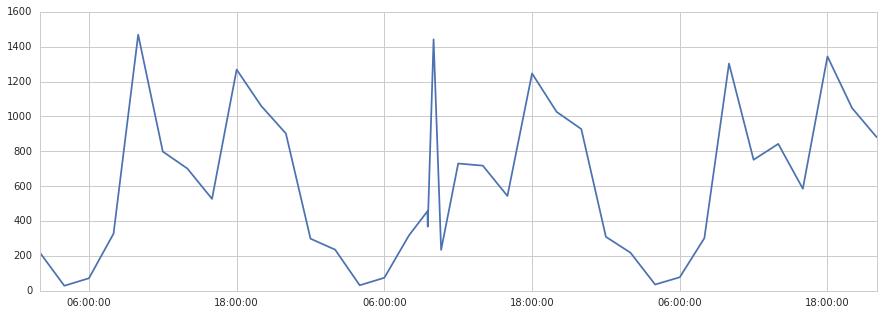

In [58]:
df_ts = df_clean.query("STATION == '34 ST-PENN STA'").query('date_time > "3/30/16"').groupby(by=['date_time'])['total_volume'].mean()
print df_ts.describe()
plt.figure(figsize=(15,5))
plt.plot(df_ts.keys(), df_ts.values)

count      18.000000
mean      913.511501
std       567.334518
min        45.973684
25%       556.197368
50%       887.697368
75%      1353.388158
max      1720.131579
Name: total_volume, dtype: float64


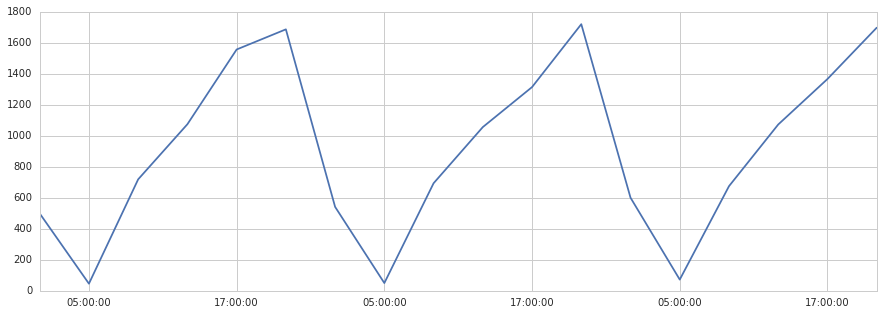

In [59]:
df_ts = df_clean.query("STATION == '14 ST-UNION SQ'").query('date_time > "3/30/16"').groupby(by=['date_time'])['total_volume'].mean()
print df_ts.describe()
plt.figure(figsize=(15,5))
plt.plot(df_ts.keys(), df_ts.values)

What's the disparity between the top volume stations and the rest?

(array([ 287.,   51.,   16.,    6.,    5.,    2.,    3.,    1.,    1.,    1.]),
 array([    14395. ,   1177722.3,   2341049.6,   3504376.9,   4667704.2,
          5831031.5,   6994358.8,   8157686.1,   9321013.4,  10484340.7,
         11647668. ]),
 <a list of 10 Patch objects>)

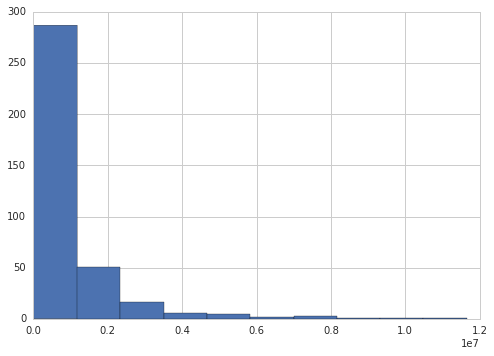

In [60]:
plt.hist(total_station_volume)

<Container object of 373 artists>

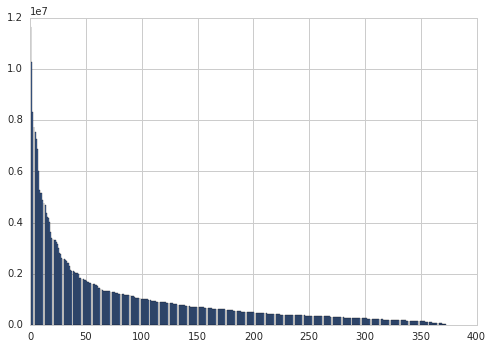

In [61]:
indices = range(len(total_station_volume))
#ar = np.array(total_station_volume)
plt.bar(indices, total_station_volume)

In [62]:
df_weekdays = df_clean.query('day_of_week_num not in [5,6]')
df_core = df_weekdays.query('rounded_time not in [0,4]')

In [63]:
df_core['rounded_time'].value_counts()

8     147229
12    137137
16    136121
20    135405
Name: rounded_time, dtype: int64

In [64]:
#get the data for the top stations based on total volume over the period of time the data was sampled
df_top = df_core[df_core['STATION'].isin(top_stations.keys()[:8])]

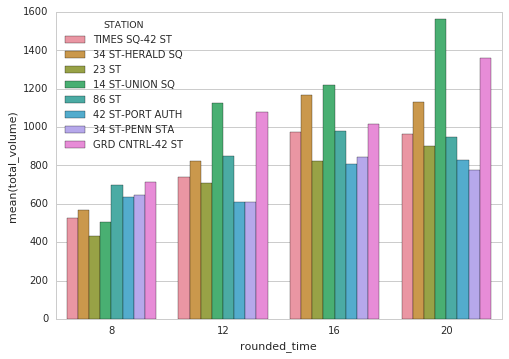

In [65]:
sns.barplot(x='rounded_time', y="total_volume", hue="STATION", data=df_top, ci=None)

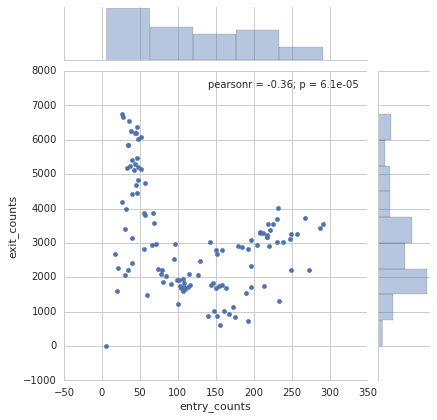

In [66]:
wtc = df_core.query('STATION == "PATH WTC 2"')
sns.jointplot(wtc['entry_counts'], wtc['exit_counts'])